In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
import torch.nn as nn

from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import make_grid

import itertools

%matplotlib inline

# Fitting a variational auto-encoder

In part one of this coursework, you will fit a variational autoencoder to the MNIST dataset.

We'll download the data and plot a few images.

In [2]:
# Download the dataset and apply necessary transformations

mnist_transforms = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.round())])
mnist_dataset = MNIST(root='data/', download=True, train=True, transform=mnist_transforms)
train_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=100, shuffle=True)

## Data format

Each MNIST image $x_i$ is a **binary image** with shape `(1, 28, 28)`, i.e.

$$x_i \in \{0, 1\}^{1\times28\times28}$$

The first dimension is the number of "channels". It is `1` because these are black-and-white images. (For color images, there are three channels.)

The convention in pytorch is for images to be `[channels][rows][columns]`. This is different than numpy, which you might be familiar with, which instead has `[rows][columns][channels]`. We will have to call `torch.permute` to re-arrange the axes, sometimes.

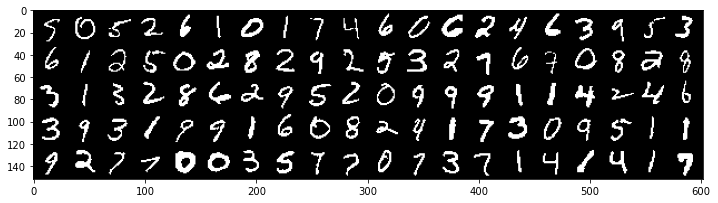

In [3]:
plt.figure(figsize=(12,5))
X_random_batch, y_random_batch = next(iter(train_loader))
plt.imshow(make_grid(X_random_batch, nrow=20).permute(1,2,0));

In [4]:
class Encoder(nn.Module):
    
    def __init__(self, D_latent):
        """ 
        Initialize the Encoder `nn.Module`.
        
        This will operate on inputs of shape (batch_size, 1, 28, 28).
        
        INPUTS:
        D_latent: size of latent space (integer)

        """
        super().__init__()
        self.D_latent = D_latent
        
        self.enc = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3, stride = 2, padding = 0), 
            nn.ReLU(),
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 2, padding = 0),
            nn.ReLU(),
            
        )
        self.fc_mu = nn.Linear(32*6*6, D_latent)
        self.fc_log_var = nn.Linear(32*6*6, D_latent)
        
        

    def forward(self, X):

        x = self.enc(X)


        mu = self.fc_mu(x.view(x.shape[0], -1))
        log_var = self.fc_log_var(x.view(x.shape[0], -1))
        
        sigma = torch.exp(log_var/2)
        
        assert mu.shape == (X.shape[0], self.D_latent)
        assert mu.shape == sigma.shape
        
        return dist.Normal(mu, sigma)


In [5]:
class Decoder(nn.Module):
    
    def __init__(self, D_latent):
        """ 
        Initialize the Decoder `nn.Module`.
        
        This will operate on inputs of shape (batch_size, D_latent).
        
        INPUTS:
        D_latent: size of latent space (integer)

        """
        super().__init__()
        self.D_latent = D_latent

        self.fc1 = nn.Linear(D_latent, 7*7*16)
        
        self.dec1 =nn.ConvTranspose2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 2, padding = 1)
        self.dec2 = nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = 3, stride = 2, padding =  1,output_padding = 1)
        self.dec3 = nn.ConvTranspose2d(in_channels = 16, out_channels = 1, kernel_size = 3, stride = 1, padding =  0,output_padding = 0)
        
    def forward(self, Z):
        """ Return a distribution p(x | z) 
                
        INPUT:
        X    : torch.FloatTensor, real-valued, shape = (batch_size, D_latent)
        
        OUTPUT: a `torch.Distribution` instance, defined on values of shape = (batch_size, 1, 28, 28)
        """
        relu = nn.ReLU()
        Z = relu(self.fc1(Z))
        Z = Z.view(-1, 16, 7, 7)
        Z = relu(self.dec1(Z))
        Z = relu(self.dec2(Z))

        X_hat = self.dec3(Z)
        X_hat = torch.sigmoid(X_hat)
        
        
        return dist.Bernoulli(X_hat.reshape(-1, 1, 28, 28))




In [6]:
def ELBO_VAE(enc, dec, X):
    """
    
    INPUT:
    enc : Instance of `Encoder` class, which returns a distribution 
          over Z when called on a batch of inputs X
    dec : Instance of `Decoder` class, which returns a distribution 
          over X when called on a batch of inputs Z
    X   : A batch of datapoints, torch.FloatTensor of shape = (batch_size, 1, 28, 28).
    
    """

    #prior for latent var
    
    if torch.cuda.is_available():
      X = X.cuda()
      prior_z = dist.Normal(torch.zeros(D_latent).cuda(), torch.ones( D_latent).cuda())
    else:
      prior_z = dist.Normal(torch.zeros(D_latent), torch.ones( D_latent))
    #ENCODER STEP
    q_z = enc(X)
   
    #sample latent variable
    samples = 1
    Zs = q_z.rsample([samples])
    res = 0
    for Z in Zs: 


      if torch.cuda.is_available():
        Z = Z.cuda()
      
      logprob_prior_z = prior_z.log_prob(Z).sum(dim = 1)
    
      #get logprob of latent var given x

      logprob_q_z = q_z.log_prob(Z).sum(dim = 1)
      
      #DECODER STEP
      p_x = dec(Z)

      #sample reconstructed X
      if torch.cuda.is_available():
        X_hat = p_x.sample().cuda()
      else:
        X_hat = p_x.sample()

      logprob_p_x = p_x.log_prob(X).sum(dim = (1, 2, 3))
      
      res+= ((logprob_prior_z + logprob_p_x) - logprob_q_z)/samples
    
    return res
    

In [7]:
D_latent = 10

enc = Encoder(D_latent)
dec = Decoder(D_latent)

opt_vae = torch.optim.Adam(itertools.chain(enc.parameters(), dec.parameters()))

In [ ]:

N_epochs = 10 
for epoch in range(N_epochs):
    train_loss = 0.0
    for (X, _) in train_loader:
        opt_vae.zero_grad()
        loss = -ELBO_VAE(enc, dec, X).mean()
        loss.backward()
        opt_vae.step()
        #print(loss.item() * X.shape[0] / len(mnist_dataset))
        train_loss += loss.item() * X.shape[0] / len(mnist_dataset)
    print("Epoch %d, train loss = %0.4f" % (epoch, train_loss));

Epoch 0, train loss = 179.6319
Epoch 1, train loss = 115.0762
Epoch 2, train loss = 106.7528
Epoch 3, train loss = 103.0106
Epoch 4, train loss = 100.6878
Epoch 5, train loss = 99.0782
Epoch 6, train loss = 97.8798


## Do reconstructions look like the input?

In [ ]:
plt.figure(figsize=(12, 4))
plt.imshow(make_grid(X_random_batch, nrow=20).permute(1,2,0))
plt.title("Input images")
plt.figure(figsize=(12, 4))
plt.title("Reconstructions")
with torch.no_grad():
    plt.imshow(make_grid(dec(enc(X_random_batch).sample()).mean, nrow=20).permute(1,2,0))

## Do randomly generated samples look coherent?

In [ ]:
plt.figure(figsize=(12,5))
with torch.no_grad():
    plt.imshow(make_grid(dec(dist.Normal(0, 1).sample((140, D_latent))).mean.round(), nrow=20).permute(1,2,0), vmin=0, vmax=1)

## What does the latent space look like?


In [ ]:
def plot_2d_latent(encoder, decoder):
    """ If this is a 2d latent space, it plots the latent space
        If the latent space is larger than 2d, then it plots a 2d cross-section """
    W = torch.linalg.svd(encoder(X_random_batch).mean).Vh[:2]
    points = dist.Normal(0, 1).icdf(torch.linspace(0.01, 0.99, 15))
    XX, YY = torch.meshgrid(points, points)
    XXYY = torch.stack((XX, YY)).reshape(2, -1).T
    with torch.no_grad():
        out = dec(XXYY @ W).mean
    plt.imshow(make_grid(out, nrow=len(points)).permute(1,2,0))

plt.figure(figsize=(10, 10))
out = plot_2d_latent(enc, dec)